### Load libraries

In [1]:
from ast import literal_eval
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("ggplot")

In [5]:
df = pd.read_csv("open_myers_briggs2.csv").rename(columns={"front": "prompt_in_front"})

df.body = df.body.astype(bool)
df.prompt_in_front = df.prompt_in_front.astype(bool)
df.binarized = df.binarized.astype(bool)

df["n_classes"] = df.classes.str.count(",") + 1
df["baseline_acc"] = 1 / df.n_classes
df["baseline_loss"] = -np.log(df.baseline_acc)

assert len(df[(df.binarized & (df.n_classes != 2))]) == 0
assert len(df[(~df.binarized & (df.n_classes == 2))]) == 0

print(len(df))
df.head()

299


,prompt,classes,answer_index,source_dataset,body,Q_id,prompt_in_front,binarized,n_classes,baseline_acc,baseline_loss
0,"For each pair, please choose a number from 1 t...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,open_myers_briggs,False,0,True,False,5,0.2,1.609438
1,"For each pair, please choose a number from 1 t...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,open_myers_briggs,False,1,True,False,5,0.2,1.609438
2,"For each pair, please choose a number from 1 t...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,open_myers_briggs,False,2,True,False,5,0.2,1.609438
3,"For each pair, please choose a number from 1 t...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,open_myers_briggs,False,3,True,False,5,0.2,1.609438
4,"For each pair, please choose a number from 1 t...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,open_myers_briggs,False,4,True,False,5,0.2,1.609438


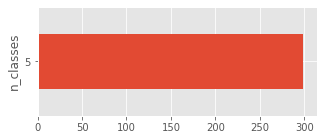

In [6]:
plt.figure(figsize=(5, 2))
df.groupby("n_classes").size().plot.barh();

### Load evaluation results

In [7]:
CSV_MAP: dict[str, str] = {
    "ada": "ada.csv",
    "babbage": "babbage.csv",
    "curie": "curie.csv",
    "davinci": "davinci.csv",
    "ada_rlhf": "text-ada-001.csv",
    "babbage_rlhf": "text-babbage-001.csv",
    "curie_rlhf": "text-curie-001.csv",
    "davinci_rlhf": "text-davinci-001.csv",
    "opt_125m": "opt-125m.csv",
    "opt_350m": "opt-350m.csv",
    "opt_1_3b": "opt-1.3b.csv",
    "opt_2_7b": "opt-2.7b.csv",
}

GPT3_SIZES = {
    # GPT-3 sizes are based on https://blog.eleuther.ai/gpt3-model-sizes/
    "ada": 350_000_000,
    "babbage": 1_300_000_000,
    "curie": 6_700_000_000,
    "davinci": 175_000_000_000,
}

GPT3_RLHF_SIZES = {
    "ada_rlhf": 350_000_000,
    "babbage_rlhf": 1_300_000_000,
    "curie_rlhf": 6_700_000_000,
    "davinci_rlhf": 175_000_000_000,
}

OPT_SIZES = {
    # opt sizes from their names
    "opt_125m": 125_000_000,
    "opt_350m": 350_000_000,
    "opt_1_3b": 1_300_000_000,
    "opt_2_7b": 2_700_000_000,
}

OGPT_SIZES = {"opt_125m": 125_000_000} | GPT3_SIZES

In [8]:
for model_name, path in CSV_MAP.items():
    cur_df = pd.read_csv("results/open_myers_briggs2/classification/" + path)

    assert len(df) == len(cur_df)

    # Parse probs
    probs_mat = np.array([literal_eval(x) for x in cur_df.probs])
    for i in range(probs_mat.shape[1]):
        df[f"prob_{model_name}_{i}"] = probs_mat[:, i]
        df[f"pred_{model_name}"] = probs_mat.argmax(axis=1)

df.columns.sort_values()

Index(['Q_id', 'answer_index', 'baseline_acc', 'baseline_loss', 'binarized',
       'body', 'classes', 'n_classes', 'pred_ada', 'pred_ada_rlhf',
       'pred_babbage', 'pred_babbage_rlhf', 'pred_curie', 'pred_curie_rlhf',
       'pred_davinci', 'pred_davinci_rlhf', 'pred_opt_125m', 'pred_opt_1_3b',
       'pred_opt_2_7b', 'pred_opt_350m', 'prob_ada_0', 'prob_ada_1',
       'prob_ada_2', 'prob_ada_3', 'prob_ada_4', 'prob_ada_rlhf_0',
       'prob_ada_rlhf_1', 'prob_ada_rlhf_2', 'prob_ada_rlhf_3',
       'prob_ada_rlhf_4', 'prob_babbage_0', 'prob_babbage_1', 'prob_babbage_2',
       'prob_babbage_3', 'prob_babbage_4', 'prob_babbage_rlhf_0',
       'prob_babbage_rlhf_1', 'prob_babbage_rlhf_2', 'prob_babbage_rlhf_3',
       'prob_babbage_rlhf_4', 'prob_curie_0', 'prob_curie_1', 'prob_curie_2',
       'prob_curie_3', 'prob_curie_4', 'prob_curie_rlhf_0',
       'prob_curie_rlhf_1', 'prob_curie_rlhf_2', 'prob_curie_rlhf_3',
       'prob_curie_rlhf_4', 'prob_davinci_0', 'prob_davinci_1',
     

In [44]:
def get_comparison(prompt: str):
    a = prompt.index('Pair: ') + len('Pair: ')
    prompt = prompt[a:-len('. Choice:')]
    prompt = prompt.replace("'", "")
    prompt = prompt.replace(' versus ', '; ')
    return prompt

In [138]:
with open('scoring.txt') as f:
    score_lines = [l[:-1] for l in f]
    score_lines = [l.replace("'", "") for l in score_lines]
    score_lines = [l.replace("\\", "") for l in score_lines]
    score_lines = [line.split('\t') for line in score_lines]


def get_score_coeffs(score_list):
    # scoring high (i.e. 5) puts you in the given direction. 
    # IE_score is negative for I, positive for E, and similarly for SN, FT, JP.
    # so I, S, F, J get negative, the others get positive.
    # ['0.19E', '0.40S', '0.32T', '0.83J'] to [0.19, -0.405, 0.32, -0.83]
    letters = [s[-1:] for s in score_list]
    numbers = [float(s[:-1]) for s in score_list]
    if letters[0] == 'I':
        numbers[0] = numbers[0] * -1
    if letters[1] == 'S':
        numbers[1] = numbers[1] * -1
    if letters[2] == 'F':
        numbers[2] = numbers[2] * -1
    if letters[3] == 'J':
        numbers[3] = numbers[3] * -1

    return np.array(numbers)


SCORE_DICT = {comparison: get_score_coeffs(scores) for [comparison, *scores] in score_lines}
for i in list(SCORE_DICT.keys())[0:5]:
    print(f'{i}: {SCORE_DICT[i]}')

likes action; likes drama: [-0.14  0.18 -0.49  0.21]
realistic; imaginative: [ 0.12  0.63 -0.71  0.71]
criticism leads to feelings of guilt; criticism leads to feelings of anger: [ 0.16 -0.08  0.56 -0.09]
loses track of time; good sense of time: [ 0.19 -0.4   0.32 -0.83]
angry; resentful: [-0.21  0.02 -0.   -0.04]


In [139]:
def get_max_scores():
    sums = np.array([0., 0., 0., 0.])
    for score_coeffs in SCORE_DICT.values():
        sums += np.abs(score_coeffs)

    return sums * 2
    

MAX_SCORES = get_max_scores()

In [140]:
def score_df(model_df):
    scores = np.array([0., 0., 0., 0.])

    # 1. generate comparison for each row
    # 2. add 
    for i in range(len(model_df)):
        row = model_df.iloc[i]
        comparison = get_comparison(row['prompt'])
        score_coeffs = SCORE_DICT[comparison]
        question_probs = np.array(list(row)[1:])
        assert abs(question_probs.sum() - 1) < 0.01, question_probs.sum()
        expected_score = (question_probs * np.array([1,2,3,4,5])).sum()
        # normalize to zero
        normalized_score = expected_score - 3
        # add result to each score
        scores += normalized_score * score_coeffs

    # normalize scores by max possible value
    scores = scores / MAX_SCORES
    assert np.all(np.abs(scores) <= 1)
    return dict(zip(['IE', 'SN', 'FT', 'JP'], scores))


# Evaluate the models

In [144]:
MODEL_SCORES = {}
for model_name in CSV_MAP.keys():
    columns = ['prompt'] + [f'prob_{model_name}_{i}' for i in range(5)]
    model_df = df[columns]
    scores = score_df(model_df)
    print(f"model {model_name}: scores: {scores}")
    MODEL_SCORES[model_name] = scores


model ada: scores: {'IE': -0.06075463966720187, 'SN': -0.27502487732792097, 'FT': -0.1605230694295247, 'JP': -0.3196297181636905}
model babbage: scores: {'IE': -0.05136599974028208, 'SN': -0.2351731551726783, 'FT': -0.13823162484941154, 'JP': -0.2786458279770405}
model curie: scores: {'IE': -0.05069633698292961, 'SN': -0.22516801441235018, 'FT': -0.1221321961052975, 'JP': -0.2660343600864837}
model davinci: scores: {'IE': -0.0519697084554405, 'SN': -0.27297381416508004, 'FT': -0.16564892340563486, 'JP': -0.3132095397157968}
model ada_rlhf: scores: {'IE': -0.01592841036722011, 'SN': -0.21849567895572988, 'FT': -0.09652425579381121, 'JP': -0.19859931990159047}
model babbage_rlhf: scores: {'IE': -0.0668051520834476, 'SN': -0.29144475902562095, 'FT': -0.1619122443006885, 'JP': -0.34600071944859767}
model curie_rlhf: scores: {'IE': -0.03118511985975623, 'SN': -0.19382467408289963, 'FT': -0.10348092897269626, 'JP': -0.22024101720910466}
model davinci_rlhf: scores: {'IE': -0.06897041436953631

In [ ]:
# Plotting
['ada', 'babbage', 'curie', 'davinchi']

In [159]:
def gen_plots(
    size_dict: dict[str, int],
    title: str = "",
):
    models = list(size_dict.keys())
    sizes = np.array(list(size_dict.values()))
    IE_scores = [MODEL_SCORES[model]['IE'] for model in models]
    SN_scores = [MODEL_SCORES[model]['SN'] for model in models]
    FT_scores = [MODEL_SCORES[model]['FT'] for model in models]
    JP_scores = [MODEL_SCORES[model]['JP'] for model in models]

    plt.figure(figsize=(8, 4))
    plt.suptitle(title + f" (n={len(df)})")
    plt.tight_layout()

    def common_plot_setup(baseline: float):
        plt.axhline(
            baseline,
            linestyle="--",
            color="black",
            zorder=-1,
            # label="random baseline",
        )
        plt.xscale("log")
        # plt.xlabel("Model size")
        plt.xticks(sizes, models)
        plt.legend()

    plt.plot(sizes, IE_scores, label="IE")
    plt.plot(sizes, SN_scores, label="SN")
    plt.plot(sizes, FT_scores, label="FT")
    plt.plot(sizes, JP_scores, label="JP")
    # plt.ylim(-1.02, 1.02)
    common_plot_setup(0.0)

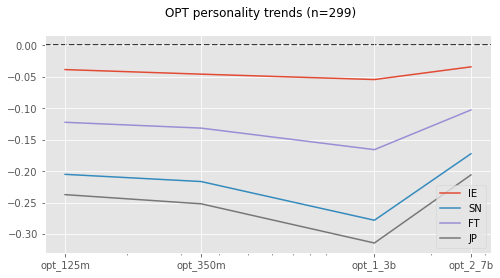

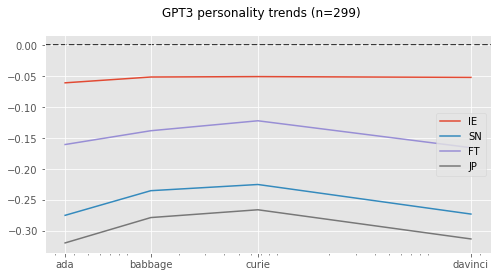

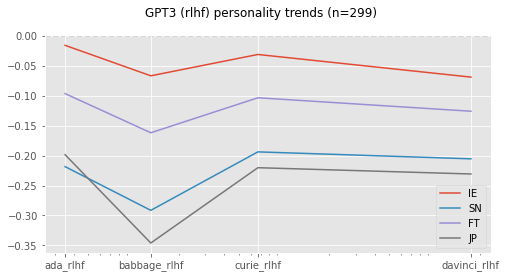

In [160]:
gen_plots(OPT_SIZES, title=f"OPT personality trends")
gen_plots(GPT3_SIZES, title=f"GPT3 personality trends")
gen_plots(GPT3_RLHF_SIZES, title=f"GPT3 (rlhf) personality trends")